In [46]:
class SVMTrainer(object):
    def __init__(self, kernel, c):
        self._kernel = kernel
        self._c = c

    def train(self, X, y):
        """Given the training features X with labels y, returns a SVM
        predictor representing the trained SVM.
        """
        lagrange_multipliers = self._compute_multipliers(X, y)
        return self._construct_predictor(X, y, lagrange_multipliers)

    def _gram_matrix(self, X):
        n_samples, n_features = X.shape
        K = np.zeros((n_samples, n_samples))
        # TODO(tulloch) - vectorize
        for i, x_i in enumerate(X):
            for j, x_j in enumerate(X):
                K[i, j] = self._kernel(x_i, x_j)
        return K

    def _construct_predictor(self, X, y, lagrange_multipliers):
        support_vector_indices = \
            lagrange_multipliers > 1e-7 #MIN_SUPPORT_VECTOR_MULTIPLIER

        support_multipliers = lagrange_multipliers[support_vector_indices]
        support_vectors = X[support_vector_indices]
        support_vector_labels = y[support_vector_indices]

        # http://www.cs.cmu.edu/~guestrin/Class/10701-S07/Slides/kernels.pdf
        # bias = y_k - \sum z_i y_i  K(x_k, x_i)
        # Thus we can just predict an example with bias of zero, and
        # compute error.
        bias = np.mean(
            [y_k - SVMPredictor(
                kernel=self._kernel,
                bias=0.0,
                weights=support_multipliers,
                support_vectors=support_vectors,
                support_vector_labels=support_vector_labels).predict(x_k)
             for (y_k, x_k) in zip(support_vector_labels, support_vectors)])
        print(support_vectors.shape)

        return SVMPredictor(
            kernel=self._kernel,
            bias=bias,
            weights=support_multipliers,
            support_vectors=support_vectors,
            support_vector_labels=support_vector_labels)

    def _compute_multipliers(self, X, y):
        n_samples, n_features = X.shape

        K = self._gram_matrix(X)
        # Solves
        # min 1/2 x^T P x + q^T x
        # s.t.
        #  Gx \coneleq h
        #  Ax = b

        P = cvxopt.matrix(np.outer(y, y) * K)
        q = cvxopt.matrix(-1 * np.ones(n_samples))

        # -a_i \leq 0
        # TODO(tulloch) - modify G, h so that we have a soft-margin classifier
        G_std = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
        h_std = cvxopt.matrix(np.zeros(n_samples))

        # a_i \leq c
        G_slack = cvxopt.matrix(np.diag(np.ones(n_samples)))
        h_slack = cvxopt.matrix(np.ones(n_samples) * self._c)

        G = cvxopt.matrix(np.vstack((G_std, G_slack)))
        h = cvxopt.matrix(np.vstack((h_std, h_slack)))

        A = cvxopt.matrix(y, (1, n_samples))
        b = cvxopt.matrix(0.0)

        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        return np.ravel(solution['x'])

In [51]:
class SVMPredictor(object):
    def __init__(self,
                 kernel,
                 bias,
                 weights,
                 support_vectors,
                 support_vector_labels):
        self._kernel = kernel
        self._bias = bias
        self._weights = weights
        self._support_vectors = support_vectors
        self._support_vector_labels = support_vector_labels

    def predict(self, x):
        """
        Computes the SVM prediction on the given features x.
        """
        result = self._bias
        #print(self._support_vectors.shape)
        #print(x.shape)
        for z_i, x_i, y_i in zip(self._weights,
                                 self._support_vectors,
                                 self._support_vector_labels):
            result += z_i * y_i * self._kernel(x_i, x)

        return np.sign(result).item()

In [52]:
import numpy as np
import numpy.linalg as la


class Kernel(object):
    """Implements list of kernels from
    http://en.wikipedia.org/wiki/Support_vector_machine
    """
    @staticmethod
    def linear():
        def f(x, y):
            return np.inner(x, y)
        return f

    @staticmethod
    def gaussian(sigma):
        def f(x, y):
            exponent = -np.sqrt(la.norm(x-y) ** 2 / (2 * sigma ** 2))
            return np.exp(exponent)
        return f

    @staticmethod
    def _polykernel(dimension, offset):
        def f(x, y):
            return (offset + np.dot(x, y)) ** dimension
        return f

    @staticmethod
    def inhomogenous_polynomial(dimension):
        return Kernel._polykernel(dimension=dimension, offset=1.0)

    @staticmethod
    def homogenous_polynomial(dimension):
        return Kernel._polykernel(dimension=dimension, offset=0.0)

    @staticmethod
    def hyperbolic_tangent(kappa, c):
        def f(x, y):
            return np.tanh(kappa * np.dot(x, y) + c)
        return f

In [53]:
import logging
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import itertools
#import argh


def example(num_samples=10, num_features=2, grid_size=20, filename="svm.pdf"):
    samples = np.matrix(np.random.normal(size=num_samples * num_features)
                        .reshape(num_samples, num_features))
    labels = 2 * (samples.sum(axis=1) > 0) - 1.0
    trainer = SVMTrainer(Kernel.linear(), 0.1)
    predictor = trainer.train(samples, labels)

    plot(predictor, samples, labels, grid_size, filename)


def plot(predictor, X, y, grid_size, filename):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_size),
                         np.linspace(y_min, y_max, grid_size),
                         indexing='ij')
    flatten = lambda m: np.array(m).reshape(-1,)

    result = []
    for (i, j) in itertools.product(range(grid_size), range(grid_size)):
        point = np.array([xx[i, j], yy[i, j]]).reshape(1, 2)
        result.append(predictor.predict(point))

    Z = np.array(result).reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 cmap=cm.Paired,
                 levels=[-0.001, 0.001],
                 extend='both',
                 alpha=0.8)
    plt.scatter(flatten(X[:, 0]), flatten(X[:, 1]),
                c=flatten(y), cmap=cm.Paired)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.savefig(filename)


#if __name__ == "__main__":
 #   logging.basicConfig(level=logging.ERROR)
 #   argh.dispatch_command(example)

     pcost       dcost       gap    pres   dres
 0: -1.8894e+00 -2.0253e+00  4e+01  6e+00  2e-16
 1: -6.4355e-01 -1.8345e+00  2e+00  1e-01  5e-16
 2: -6.0085e-01 -7.8032e-01  2e-01  7e-17  5e-16
 3: -6.6483e-01 -6.8258e-01  2e-02  5e-17  2e-16
 4: -6.7427e-01 -6.7452e-01  2e-04  7e-17  1e-16
 5: -6.7443e-01 -6.7443e-01  2e-06  6e-17  2e-16
 6: -6.7443e-01 -6.7443e-01  2e-08  5e-17  2e-16
Optimal solution found.
(8, 2)


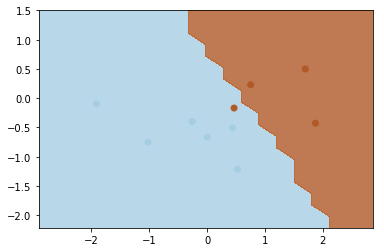

In [54]:
example()